# Build a Boolean Net to run simulation to identify point of intervention

In [1]:
import time
import pandas as pd

In [53]:
df_network = pd.read_csv('survival_apoptosis_network.csv')
df_drug = pd.read_csv('drug_node_interaction.csv')

In [54]:
df_network

,start_node,end_node,interaction
0,BCL2,BAK/BAX,-
1,BAK/BAX,Apoptosis,+
2,BCL2L11,BAK/BAX,+
3,BCL2L11,BCL2,-
4,MAP3K7,IKK-complex,+
5,MAP3K7,IKBKG,+
6,IKK-complex,FOXO3,-
7,IKK-complex,NFKBIA,-
8,IKK-complex,BAD,-
9,IKBKG,IKK-complex,+


In [55]:
df_drug

,drug,node,interaction
0,Interferon gamma-n1,TNF,-
1,Interferon gamma-1b,TNF,-
2,Interferon gamma-1a,TNF,-
3,Ruxolitinib,MEK1/2,-
4,Dasatinib,MEK1/2,-
5,Dinaciclib,FOXO3,+
6,Vemurafenib,BRAF,-


In [56]:
start_nodes = df_network['start_node'].values
end_nodes = df_network['end_node'].values

In [57]:
# find dangling nodes without incoming path as initiating points
dangling_nodes = list()
for start_node in start_nodes:
    if start_node not in end_nodes and start_node not in dangling_nodes:
        dangling_nodes.append(start_node)

In [58]:
print("Number of initiating nodes: %i" %len(dangling_nodes))
for node in dangling_nodes:
    print(node)

Number of initiating nodes: 5
AKT
Survival_factors
TNF
FOXO1
XIAP


# Explanation on the 5 initiating nodes

In [59]:
all_nodes = list(set(start_nodes).union(set(end_nodes)))
for node in all_nodes:
    print(node)
print(len(all_nodes))

NFKBIA
AKT
FOXO3
BAD
IKK-complex
IKBKG
BAK/BAX
BCL2L11
Apoptosis
Survival
NRAS
MAP3K7
TRADD
TRAF2
CASP7
CREB1
NfKb-p65/p50
MEK1/2
Survival_factors
RPS6KA1
CASP3
SOS1
TNFRSF1A
XIAP
FOXO1
CASP9
GRB2
ERK1/2
BRAF
TNF
BCL2
31


In [60]:
def weights(sign):
    if sign=="+":
        return 1
    return -1
df_weighted_network = df_network.copy()
df_weighted_network['weight']=df_weighted_network['interaction'].apply(weights)

In [61]:
df_weighted_network.head()

,start_node,end_node,interaction,weight
0,BCL2,BAK/BAX,-,-1
1,BAK/BAX,Apoptosis,+,1
2,BCL2L11,BAK/BAX,+,1
3,BCL2L11,BCL2,-,-1
4,MAP3K7,IKK-complex,+,1


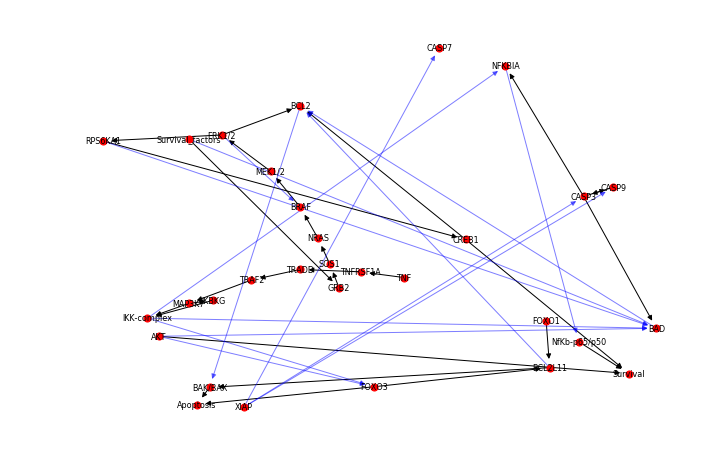

In [63]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
%matplotlib inline

figure(num=None, figsize=(12, 8))


DG = nx.DiGraph()

for i in range(len(df_weighted_network)):
    DG.add_edge(df_weighted_network.loc[i,'start_node'], 
                df_weighted_network.loc[i,'end_node'], 
                weight=df_weighted_network.loc[i,'weight'])

elarge = [(u, v) for (u, v, d) in DG.edges(data=True) if d['weight'] == 1]
esmall = [(u, v) for (u, v, d) in DG.edges(data=True) if d['weight'] == -1]

pos = nx.spring_layout(DG)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(DG, pos, node_size=50)

# edges
nx.draw_networkx_edges(DG, pos, edgelist=elarge,
                       width=1)
nx.draw_networkx_edges(DG, pos, edgelist=esmall,
                       width=1, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(DG, pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()


# To build the logical rules govern the behavior of each node

In [66]:
# Test case
df_network[df_network['end_node']=='BCL2']

,start_node,end_node,interaction
3,BCL2L11,BCL2,-
15,CREB1,BCL2,+
20,ERK1/2,BCL2,+
36,BAD,BCL2,-


In [67]:
node_rule_dictionary = dict()
node_rule_dictionary['BCL2'] = df_network[df_network['end_node']=='BCL2'].to_numpy()

In [68]:
print (node_rule_dictionary)

{'BCL2': array([['BCL2L11', 'BCL2', '-'],
       ['CREB1', 'BCL2', '+'],
       ['ERK1/2', 'BCL2', '+'],
       ['BAD', 'BCL2', '-']], dtype=object)}


In [69]:
node_rule_table = dict()
for node in all_nodes:
    node_rule_table[node] = df_network[df_network['end_node']==node].to_numpy()  

In [72]:
with open('node_rule_table.txt','w') as data:
    data.write(str(node_rule_table)) # the text table will be massaged outside the script and then input back.

In [21]:
f = file('default_network.txt','r').read()

In [22]:
f

"\xef\xbb\xbfAKT = FOXO1 = Survival_factors = XIAP = TNF = Random\rNFKBIA* =  not IKK-complex and CASP3\rFOXO3* = not IKK-complex and not AKT \rBAD* = not IKK-complex and not AKT and not Survival_factors and not \rRPS6KA1\rIKK-complex* = MAP3K7 and IKBKG\rIKBKG* = MAP3K7\rBAK/BAX* =  not BCL2 and BCL2L11\rBCL2L11* = FOXO3 and FOXO1\rApoptosis* = BAK/BAX and FOXO3\rSurvival* = NfKb-p65/p50 and CREB1 and AKT\rNRAS* = SOS1\rMAP3K7* = TRAF2\rTRADD* = TNFRSF1A\rTRAF2* = TRADD\rRPS6KA1* = ERK1/2\rCREB1* = RPS6KA1\rNfKb-p65/p50* = not NFKBIA\rMEK1/2* = BRAF\rCASP7* = not XIAP\rCASP3* = not 'XIAP' and CASP9\rSOS1* = GRB2\rTNFRSF1A* = TNF\rCASP9* = CASP3 and not XIAP\rGRB2* = Survival_factors\rERK1/2* = MEK1/2\rBRAF* = not ERK1/2 and NRAS\rBCL2* = not BCL2L11 and CREB1 and ERK1/2 and not BAD\r"

In [1]:
import boolean2

In [2]:
# This model would assume the cell is a normal cell without any sign of turning maglignant.
Default_model = """
Survival_factors = False
AKT = FOXO1 = XIAP = TNF = Random

MEK1_2 = NFKBIA = BAK_BAX = FOXO3 = BAD = IKK-complex = IKBKG = BCL2L11 = Apoptosis = Survival = NRAS = MAP3K7 = TRADD = TRAF2 = CASP7 = CREB1 = ERK1_2 = RPS6KA1 = NfKb-p65_p50 = CASP3 = SOS1 = TNFRSF1A = CASP9 = GRB2 = BRAF = BCL2 = False
NFKBIA* =  not IKK-complex and CASP3
FOXO3* = not IKK-complex and not AKT 
BAD* = not IKK-complex and not AKT and not Survival_factors and not RPS6KA1
IKK-complex* = MAP3K7 and IKBKG
IKBKG* = MAP3K7
BAK_BAX* =  not BCL2 and BCL2L11
BCL2L11* = FOXO3 and FOXO1
Apoptosis* = BAK_BAX and FOXO3
Survival* = NfKb-p65_p50 and CREB1 and AKT
NRAS* = SOS1
MAP3K7* = TRAF2
TRADD* = TNFRSF1A
TRAF2* = TRADD
RPS6KA1* = ERK1_2
CREB1* = RPS6KA1
NfKb-p65_p50* = not NFKBIA
MEK1_2* = BRAF
CASP7* = not XIAP
CASP3* = not XIAP and CASP9
SOS1* = GRB2
TNFRSF1A* = TNF
CASP9* = CASP3 and not XIAP
GRB2* = Survival_factors
ERK1_2* = MEK1_2
BRAF* = not ERK1_2 and NRAS
BCL2* = not BCL2L11 and CREB1 and ERK1_2 and not BAD
"""

In [3]:
model = boolean2.Model(Default_model, mode='async')
model.initialize()
model.iterate(steps=100)
state = model.states[-1]
print (state.Survival, state.Apoptosis)
model.report_cycles()

(False, False)
Steady state starting at index 1 -> State: AKT=False, Apoptosis=False, BAD=True, BAK_BAX=False, BCL2=False, BCL2L11=False, BRAF=False, CASP3=False, CASP7=True, CASP9=False, CREB1=False, ERK1_2=False, FOXO1=False, FOXO3=True, GRB2=False, IKBKG=False, IKK-complex=False, MAP3K7=False, MEK1_2=False, NFKBIA=False, NRAS=False, NfKb-p65_p50=True, RPS6KA1=False, SOS1=False, Survival=False, Survival_factors=False, TNF=False, TNFRSF1A=False, TRADD=False, TRAF2=False, XIAP=False


In [4]:
# Since the simulation is updated randomly, I will collect a series of simulation runs
# to average out the outcome
import time
from boolean2 import util
coll = util.Collector()
start_time = time.time()
survival = list()
apoptosis = list()
for i in range(100):
    model = boolean2.Model(Default_model, mode='async')
    model.initialize()
    model.iterate(steps=100)
    # we only observe two nodes: "Survival" and "Apoptosis"
    nodes = model.nodes
    coll.collect(states=model.states, nodes = ['Survival','Apoptosis'])

avgs = coll.get_averages(normalize=True)
print (avgs)
print ("Average survival probability: %.4f" %(float(sum(model.data['Survival']))/len(model.data['Survival'])))
print ("CPU runtime: %.2f" %(time.time()-start_time))

{'Apoptosis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Survival': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [22]:
# This model would assume the cell has show signs of turning maglignant.
cancer_cell = """
Survival_factors = AKT = XIAP = True
FOXO1 = False
TNF = Random

MEK1_2 = NFKBIA = BAK_BAX = FOXO3 = BAD = IKK-complex = IKBKG = BCL2L11 = Apoptosis = Survival = NRAS = MAP3K7 = TRADD = TRAF2 = CASP7 = CREB1 = ERK1_2 = RPS6KA1 = NfKb-p65_p50 = CASP3 = SOS1 = TNFRSF1A = CASP9 = GRB2 = BRAF = BCL2 = False
NFKBIA* =  not IKK-complex and CASP3
FOXO3* = not IKK-complex and not AKT 
BAD* = not IKK-complex and not AKT and not Survival_factors and not RPS6KA1
IKK-complex* = MAP3K7 and IKBKG
IKBKG* = MAP3K7
BAK_BAX* =  not BCL2 and BCL2L11
BCL2L11* = FOXO3 and FOXO1
Apoptosis* = BAK_BAX and FOXO3
Survival* = NfKb-p65_p50 and CREB1 and AKT
NRAS* = SOS1
MAP3K7* = TRAF2
TRADD* = TNFRSF1A
TRAF2* = TRADD
RPS6KA1* = ERK1_2
CREB1* = RPS6KA1
NfKb-p65_p50* = not NFKBIA
MEK1_2* = BRAF
CASP7* = not XIAP
CASP3* = not XIAP and CASP9
SOS1* = GRB2
TNFRSF1A* = TNF
CASP9* = CASP3 and not XIAP
GRB2* = Survival_factors
ERK1_2* = MEK1_2
BRAF* = not ERK1_2 and NRAS
BCL2* = not BCL2L11 and CREB1 and ERK1_2 and not BAD
"""

In [23]:
model = boolean2.Model(cancer_cell, mode='async')
model.initialize()
model.iterate(steps=100)
state = model.states[-1]
print (state.Survival, state.Apoptosis)
model.report_cycles()

(False, False)
No cycle or steady state could be detected from the 101 states


In [56]:
import time
from boolean2 import util
coll = util.Collector()
start_time = time.time()
for i in range(100):
    model = boolean2.Model(cancer_cell, mode='async')
    model.initialize()
    model.iterate(steps=100)
    # we only observe two nodes: "Survival" and "Apoptosis"
    nodes = model.nodes
    coll.collect(states=model.states, nodes = ['Survival','Apoptosis'])

avgs = coll.get_averages(normalize=True)
print (avgs)
print ("Average survival probability: %.4f" %(float(sum(model.data['Survival']))/len(model.data['Survival'])))
print ("CPU runtime: %.2f" %(time.time()-start_time))

{'Apoptosis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Survival': [0.0, 0.0, 0.0, 0.03, 0.11, 0.44, 0.53, 0.46, 0.47, 0.52, 0.56, 0.44, 0.47, 0.62, 0.51, 0.53, 0.49, 0.47, 0.51, 0.53, 0.53, 0.46, 0.44, 0.48, 0.5, 0.41, 0.52, 0.57, 0.6, 0.48, 0.6, 0.66, 0.52, 0.51, 0.58, 0.46, 0.46, 0.51, 0.57, 0.47, 0.53, 0.57, 0.48, 0.37, 0.51, 0.53, 0.4, 0.4, 0.52, 0.5, 0.5, 0.44, 0.5, 0.44, 0.5, 0.45, 0.55, 0.5, 0.47, 0.44, 0.49, 0.63, 0.52, 0.53, 0.5, 0.52, 0.55, 0.51, 0.5, 0.49, 0.53, 0.52, 0.44, 0.46, 0.51, 0.49, 0.5, 0.51, 0.59, 0.58, 0.

In [42]:
# This model would assume the cell has show signs of turning maglignant
# and Interferon treatment is applied
cancer_cell_interferon = """
Survival_factors = AKT = XIAP = True
FOXO1 = False
TNF = Random

Interferon_gamma-n1 = Interferon_gamma-1b = Interferon_gamma-1a = True
TNF* = not Interferon_gamma-n1 or not Interferon_gamma-1b or not Interferon_gamma-1a

MEK1_2 = NFKBIA = BAK_BAX = FOXO3 = BAD = IKK-complex = IKBKG = BCL2L11 = Apoptosis = Survival = NRAS = MAP3K7 = TRADD = TRAF2 = CASP7 = CREB1 = ERK1_2 = RPS6KA1 = NfKb-p65_p50 = CASP3 = SOS1 = TNFRSF1A = CASP9 = GRB2 = BRAF = BCL2 = False
NFKBIA* =  not IKK-complex and CASP3
FOXO3* = not IKK-complex and not AKT 
BAD* = not IKK-complex and not AKT and not Survival_factors and not RPS6KA1
IKK-complex* = MAP3K7 and IKBKG
IKBKG* = MAP3K7
BAK_BAX* =  not BCL2 and BCL2L11
BCL2L11* = FOXO3 and FOXO1
Apoptosis* = BAK_BAX and FOXO3
Survival* = NfKb-p65_p50 and CREB1 and AKT
NRAS* = SOS1
MAP3K7* = TRAF2
TRADD* = TNFRSF1A
TRAF2* = TRADD
RPS6KA1* = ERK1_2
CREB1* = RPS6KA1
NfKb-p65_p50* = not NFKBIA
MEK1_2* = BRAF
CASP7* = not XIAP
CASP3* = not XIAP and CASP9
SOS1* = GRB2
TNFRSF1A* = TNF
CASP9* = CASP3 and not XIAP
GRB2* = Survival_factors
ERK1_2* = MEK1_2
BRAF* = not ERK1_2 and NRAS
BCL2* = not BCL2L11 and CREB1 and ERK1_2 and not BAD
"""

In [43]:
model = boolean2.Model(cancer_cell_interferon, mode='async')
model.initialize()
model.iterate(steps=100)
state = model.states[-1]
print (state.Survival, state.Apoptosis)
model.report_cycles()

(False, False)
No cycle or steady state could be detected from the 101 states


In [57]:
import time
from boolean2 import util
coll = util.Collector()
start_time = time.time()
for i in range(100):
    model = boolean2.Model(cancer_cell_interferon, mode='async')
    model.initialize()
    model.iterate(steps=100)
    # we only observe two nodes: "Survival" and "Apoptosis"
    nodes = model.nodes
    coll.collect(states=model.states, nodes = ['Survival','Apoptosis'])

avgs = coll.get_averages(normalize=True)
print (avgs)
print ("Average survival probability: %.4f" %(float(sum(model.data['Survival']))/len(model.data['Survival'])))
print ("CPU runtime: %.2f" %(time.time()-start_time))

{'Apoptosis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Survival': [0.0, 0.0, 0.0, 0.02, 0.18, 0.44, 0.58, 0.59, 0.47, 0.49, 0.52, 0.52, 0.55, 0.4, 0.4, 0.55, 0.52, 0.44, 0.57, 0.49, 0.46, 0.57, 0.49, 0.47, 0.57, 0.46, 0.52, 0.53, 0.56, 0.5, 0.45, 0.64, 0.59, 0.48, 0.55, 0.56, 0.5, 0.48, 0.59, 0.47, 0.53, 0.54, 0.47, 0.51, 0.52, 0.46, 0.43, 0.45, 0.44, 0.46, 0.58, 0.54, 0.48, 0.53, 0.58, 0.5, 0.56, 0.56, 0.62, 0.5, 0.55, 0.57, 0.48, 0.53, 0.51, 0.46, 0.5, 0.53, 0.51, 0.5, 0.5, 0.58, 0.48, 0.48, 0.59, 0.49, 0.51, 0.44, 0.53, 0.41

In [39]:
# This model would assume the cell has show signs of turning maglignant
# and Interferon and Ruxolitinib or Dasatinib treatment is applied
cancer_cell_interferon_Ruxolitinib_Dasatinib = """
Survival_factors = AKT = XIAP = True
FOXO1 = False
TNF = Random

Interferon_gamma-n1 = Interferon_gamma-1b = Interferon_gamma-1a = True
TNF* = Interferon_gamma-n1 or Interferon_gamma-1b or Interferon_gamma-1a

Ruxolitinib = Dasatinib = True
MEK1_2* = not Ruxolitinib or not Dasatinib

MEK1_2 = NFKBIA = BAK_BAX = FOXO3 = BAD = IKK-complex = IKBKG = BCL2L11 = Apoptosis = Survival = NRAS = MAP3K7 = TRADD = TRAF2 = CASP7 = CREB1 = ERK1_2 = RPS6KA1 = NfKb-p65_p50 = CASP3 = SOS1 = TNFRSF1A = CASP9 = GRB2 = BRAF = BCL2 = False
NFKBIA* =  not IKK-complex and CASP3
FOXO3* = not IKK-complex and not AKT 
BAD* = not IKK-complex and not AKT and not Survival_factors and not RPS6KA1
IKK-complex* = MAP3K7 and IKBKG
IKBKG* = MAP3K7
BAK_BAX* =  not BCL2 and BCL2L11
BCL2L11* = FOXO3 and FOXO1
Apoptosis* = BAK_BAX and FOXO3
Survival* = NfKb-p65_p50 and CREB1 and AKT
NRAS* = SOS1
MAP3K7* = TRAF2
TRADD* = TNFRSF1A
TRAF2* = TRADD
RPS6KA1* = ERK1_2
CREB1* = RPS6KA1
NfKb-p65_p50* = not NFKBIA
MEK1_2* = BRAF
CASP7* = not XIAP
CASP3* = not XIAP and CASP9
SOS1* = GRB2
TNFRSF1A* = TNF
CASP9* = CASP3 and not XIAP
GRB2* = Survival_factors
ERK1_2* = MEK1_2
BRAF* = not ERK1_2 and NRAS
BCL2* = not BCL2L11 and CREB1 and ERK1_2 and not BAD
"""

In [40]:
model = boolean2.Model(cancer_cell_interferon_Ruxolitinib_Dasatinib, mode='async')
model.initialize()
model.iterate(steps=100)
state = model.states[-1]
print (state.Survival, state.Apoptosis)
model.report_cycles()

(False, False)
Steady state starting at index 23 -> State: AKT=True, Apoptosis=False, BAD=False, BAK_BAX=False, BCL2=False, BCL2L11=False, BRAF=True, CASP3=False, CASP7=False, CASP9=False, CREB1=False, Dasatinib=True, ERK1_2=False, FOXO1=False, FOXO3=False, GRB2=True, IKBKG=True, IKK-complex=True, Interferon_gamma-1a=True, Interferon_gamma-1b=True, Interferon_gamma-n1=True, MAP3K7=True, MEK1_2=False, NFKBIA=False, NRAS=True, NfKb-p65_p50=True, RPS6KA1=False, Ruxolitinib=True, SOS1=True, Survival=False, Survival_factors=True, TNF=True, TNFRSF1A=True, TRADD=True, TRAF2=True, XIAP=True


In [60]:
import time
from boolean2 import util
coll = util.Collector()
start_time = time.time()
for i in range(100):
    model = boolean2.Model(cancer_cell_interferon_Ruxolitinib_Dasatinib, mode='async')
    model.initialize()
    model.iterate(steps=100)
    # we only observe two nodes: "Survival" and "Apoptosis"
    nodes = model.nodes
    coll.collect(states=model.states, nodes = ['Survival','Apoptosis'])

avgs = coll.get_averages(normalize=True)
print (avgs)
print ("Average survival probability: %.4f" %(float(sum(model.data['Survival']))/len(model.data['Survival'])))
print ("CPU runtime: %.2f" %(time.time()-start_time))

{'Apoptosis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Survival': [0.0, 0.0, 0.0, 0.0, 0.06, 0.16, 0.29, 0.31, 0.39, 0.36, 0.27, 0.39, 0.33, 0.28, 0.25, 0.37, 0.4, 0.41, 0.37, 0.3, 0.3, 0.31, 0.35, 0.36, 0.31, 0.31, 0.31, 0.31, 0.36, 0.33, 0.31, 0.28, 0.24, 0.3, 0.4, 0.38, 0.35, 0.39, 0.49, 0.37, 0.34, 0.29, 0.26, 0.38, 0.4, 0.36, 0.28, 0.31, 0.29, 0.36, 0.41, 0.36, 0.33, 0.34, 0.39, 0.34, 0.27, 0.33, 0.27, 0.35, 0.33, 0.32, 0.34, 0.28, 0.36, 0.32, 0.36, 0.45, 0.36, 0.39, 0.37, 0.34, 0.27, 0.35, 0.39, 0.36, 0.27, 0.26, 0.32, 0.

In [48]:
# This model would assume the cell has show signs of turning maglignant
# and Interferon and Ruxolitinib or Dasatinib and Dinaciclib treatment are applied
cancer_cell_interferon_Ruxolitinib_Dasatinib_Dinaciclib = """
Survival_factors = AKT = XIAP = True
FOXO1 = False
TNF = Random

Interferon_gamma-n1 = Interferon_gamma-1b = Interferon_gamma-1a = True
TNF* = Interferon_gamma-n1 or Interferon_gamma-1b or Interferon_gamma-1a

Ruxolitinib = Dasatinib = True
MEK1_2* = not Ruxolitinib or not Dasatinib

Dinaciclib = True
FOXO3* = Dinaciclib

MEK1_2 = NFKBIA = BAK_BAX = FOXO3 = BAD = IKK-complex = IKBKG = BCL2L11 = Apoptosis = Survival = NRAS = MAP3K7 = TRADD = TRAF2 = CASP7 = CREB1 = ERK1_2 = RPS6KA1 = NfKb-p65_p50 = CASP3 = SOS1 = TNFRSF1A = CASP9 = GRB2 = BRAF = BCL2 = False
NFKBIA* =  not IKK-complex and CASP3
FOXO3* = not IKK-complex and not AKT 
BAD* = not IKK-complex and not AKT and not Survival_factors and not RPS6KA1
IKK-complex* = MAP3K7 and IKBKG
IKBKG* = MAP3K7
BAK_BAX* =  not BCL2 and BCL2L11
BCL2L11* = FOXO3 and FOXO1
Apoptosis* = BAK_BAX and FOXO3
Survival* = NfKb-p65_p50 and CREB1 and AKT
NRAS* = SOS1
MAP3K7* = TRAF2
TRADD* = TNFRSF1A
TRAF2* = TRADD
RPS6KA1* = ERK1_2
CREB1* = RPS6KA1
NfKb-p65_p50* = not NFKBIA
MEK1_2* = BRAF
CASP7* = not XIAP
CASP3* = not XIAP and CASP9
SOS1* = GRB2
TNFRSF1A* = TNF
CASP9* = CASP3 and not XIAP
GRB2* = Survival_factors
ERK1_2* = MEK1_2
BRAF* = not ERK1_2 and NRAS
BCL2* = not BCL2L11 and CREB1 and ERK1_2 and not BAD
"""

In [46]:
model = boolean2.Model(cancer_cell_interferon_Ruxolitinib_Dasatinib_Dinaciclib, mode='async')
model.initialize()
model.iterate(steps=100)
state = model.states[-1]
print (state.Survival, state.Apoptosis)
model.report_cycles()

(False, False)
Steady state starting at index 13 -> State: AKT=True, Apoptosis=False, BAD=False, BAK_BAX=False, BCL2=False, BCL2L11=False, BRAF=True, CASP3=False, CASP7=False, CASP9=False, CREB1=False, Dasatinib=True, Dinaciclib=True, ERK1_2=False, FOXO1=False, FOXO3=False, GRB2=True, IKBKG=True, IKK-complex=True, Interferon_gamma-1a=True, Interferon_gamma-1b=True, Interferon_gamma-n1=True, MAP3K7=True, MEK1_2=True, NFKBIA=False, NRAS=True, NfKb-p65_p50=True, RPS6KA1=False, Ruxolitinib=True, SOS1=True, Survival=False, Survival_factors=True, TNF=True, TNFRSF1A=True, TRADD=True, TRAF2=True, XIAP=True


In [61]:
import time
from boolean2 import util
coll = util.Collector()
start_time = time.time()
for i in range(100):
    model = boolean2.Model(cancer_cell_interferon_Ruxolitinib_Dasatinib_Dinaciclib, mode='async')
    model.initialize()
    model.iterate(steps=100)
    # we only observe two nodes: "Survival" and "Apoptosis"
    nodes = model.nodes
    coll.collect(states=model.states, nodes = ['Survival','Apoptosis'])

avgs = coll.get_averages(normalize=True)
print (avgs)
print ("Average survival probability: %.4f" %(float(sum(model.data['Survival']))/len(model.data['Survival'])))
print ("CPU runtime: %.2f" %(time.time()-start_time))

{'Apoptosis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Survival': [0.0, 0.0, 0.0, 0.02, 0.13, 0.24, 0.38, 0.33, 0.26, 0.32, 0.25, 0.28, 0.34, 0.35, 0.31, 0.42, 0.4, 0.36, 0.36, 0.37, 0.31, 0.29, 0.45, 0.36, 0.23, 0.4, 0.42, 0.36, 0.31, 0.31, 0.34, 0.35, 0.33, 0.38, 0.39, 0.27, 0.29, 0.42, 0.36, 0.28, 0.3, 0.34, 0.28, 0.35, 0.32, 0.36, 0.35, 0.35, 0.33, 0.27, 0.31, 0.34, 0.44, 0.28, 0.26, 0.33, 0.34, 0.25, 0.31, 0.32, 0.34, 0.33, 0.3, 0.3, 0.33, 0.27, 0.26, 0.31, 0.37, 0.36, 0.29, 0.32, 0.35, 0.27, 0.29, 0.29, 0.31, 0.41, 0.32, 

In [49]:
# This model would assume the cell has show signs of turning maglignant
# and Interferon and Ruxolitinib or Dasatinib, Dinaciclib and Vemurafenib treatment are applied
cancer_cell_interferon_Ruxolitinib_Dasatinib_Dinaciclib_Vemurafenib = """
Survival_factors = AKT = XIAP = True
FOXO1 = False
TNF = Random

Interferon_gamma-n1 = Interferon_gamma-1b = Interferon_gamma-1a = True
TNF* = Interferon_gamma-n1 or Interferon_gamma-1b or Interferon_gamma-1a

Ruxolitinib = Dasatinib = True
MEK1_2* = not Ruxolitinib or not Dasatinib

Dinaciclib = True
FOXO3* = Dinaciclib

Vemurafenib = True
BRAF* = not Vemurafenib

MEK1_2 = NFKBIA = BAK_BAX = FOXO3 = BAD = IKK-complex = IKBKG = BCL2L11 = Apoptosis = Survival = NRAS = MAP3K7 = TRADD = TRAF2 = CASP7 = CREB1 = ERK1_2 = RPS6KA1 = NfKb-p65_p50 = CASP3 = SOS1 = TNFRSF1A = CASP9 = GRB2 = BRAF = BCL2 = False
NFKBIA* =  not IKK-complex and CASP3
FOXO3* = not IKK-complex and not AKT 
BAD* = not IKK-complex and not AKT and not Survival_factors and not RPS6KA1
IKK-complex* = MAP3K7 and IKBKG
IKBKG* = MAP3K7
BAK_BAX* =  not BCL2 and BCL2L11
BCL2L11* = FOXO3 and FOXO1
Apoptosis* = BAK_BAX and FOXO3
Survival* = NfKb-p65_p50 and CREB1 and AKT
NRAS* = SOS1
MAP3K7* = TRAF2
TRADD* = TNFRSF1A
TRAF2* = TRADD
RPS6KA1* = ERK1_2
CREB1* = RPS6KA1
NfKb-p65_p50* = not NFKBIA
MEK1_2* = BRAF
CASP7* = not XIAP
CASP3* = not XIAP and CASP9
SOS1* = GRB2
TNFRSF1A* = TNF
CASP9* = CASP3 and not XIAP
GRB2* = Survival_factors
ERK1_2* = MEK1_2
BRAF* = not ERK1_2 and NRAS
BCL2* = not BCL2L11 and CREB1 and ERK1_2 and not BAD
"""

In [50]:
model = boolean2.Model(cancer_cell_interferon_Ruxolitinib_Dasatinib_Dinaciclib_Vemurafenib, mode='async')
model.initialize()
model.iterate(steps=100)
state = model.states[-1]
print (state.Survival, state.Apoptosis)
model.report_cycles()

(False, False)
Steady state starting at index 19 -> State: AKT=True, Apoptosis=False, BAD=False, BAK_BAX=False, BCL2=False, BCL2L11=False, BRAF=True, CASP3=False, CASP7=False, CASP9=False, CREB1=False, Dasatinib=True, Dinaciclib=True, ERK1_2=False, FOXO1=False, FOXO3=True, GRB2=True, IKBKG=True, IKK-complex=True, Interferon_gamma-1a=True, Interferon_gamma-1b=True, Interferon_gamma-n1=True, MAP3K7=True, MEK1_2=False, NFKBIA=False, NRAS=True, NfKb-p65_p50=True, RPS6KA1=False, Ruxolitinib=True, SOS1=True, Survival=False, Survival_factors=True, TNF=True, TNFRSF1A=True, TRADD=True, TRAF2=True, Vemurafenib=True, XIAP=True


In [62]:
import time
from boolean2 import util
coll = util.Collector()
start_time = time.time()
for i in range(100):
    model = boolean2.Model(cancer_cell_interferon_Ruxolitinib_Dasatinib_Dinaciclib_Vemurafenib, mode='async')
    model.initialize()
    model.iterate(steps=100)
    # we only observe two nodes: "Survival" and "Apoptosis"
    nodes = model.nodes
    coll.collect(states=model.states, nodes = ['Survival','Apoptosis'])

avgs = coll.get_averages(normalize=True)
print (avgs)
print ("Average survival probability: %.4f" %(float(sum(model.data['Survival']))/len(model.data['Survival'])))
print ("CPU runtime: %.2f" %(time.time()-start_time))

{'Apoptosis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'Survival': [0.0, 0.0, 0.0, 0.03, 0.1, 0.16, 0.2, 0.26, 0.22, 0.17, 0.16, 0.11, 0.18, 0.27, 0.2, 0.2, 0.1, 0.13, 0.19, 0.18, 0.23, 0.2, 0.13, 0.15, 0.23, 0.21, 0.21, 0.18, 0.19, 0.18, 0.24, 0.22, 0.21, 0.2, 0.24, 0.16, 0.15, 0.15, 0.22, 0.25, 0.24, 0.21, 0.2, 0.21, 0.23, 0.17, 0.13, 0.25, 0.18, 0.22, 0.23, 0.21, 0.19, 0.24, 0.19, 0.29, 0.24, 0.2, 0.2, 0.23, 0.3, 0.15, 0.27, 0.18, 0.16, 0.17, 0.21, 0.14, 0.24, 0.22, 0.12, 0.19, 0.29, 0.21, 0.12, 0.22, 0.24, 0.19, 0.16, 0.23, 